In [1]:
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display, clear_output
from matplotlib import cm

from mlbase.networks.pytorch import neuralnetworks as nn
from mlbase.networks.pytorch.reinforcementlearning import Environment, Agent

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [12]:
class Marble(Environment):
    def __init__(self, valid_actions):
        super().__init__(valid_actions)

    def initial_state(self):
        '''[position, velocity]'''
        return np.array([10 * np.random.uniform(), 0.0])

    def next_state(self, state, action):
        '''s[0] is position, s[1] is velocity. a is -1, 0 or 1'''
        next_state = state.copy()
        deltaT = 0.1                           # Euler integration time step
        next_state[0] += deltaT * state[1]     # Update position
        force = action
        mass = 0.5
        # Update velocity. Includes friction
        next_state[1] += deltaT * (force / mass - 0.2 * state[1])

        # Bound next position. If at limits, set velocity to 0.
        if next_state[0] < 0:
            # these constants as ints were causing the errors we discussed in class. I DON'T KNOW WHY!!
            next_state = [0., 0.]
        elif next_state[0] > 10:
            next_state = [10., 0.]

        return next_state

    def reinforcement(self, state):
        goal = 5
        return 0 if abs(state[0] - goal) < 1 else -1

    def terminal_state(self, state):
        return False


class Qnet(Agent):

    def __init__(self, environment, hidden_layers, Xmeans=None, Xstds=None,
                 Qmeans=None, Qstds=None, use_gpu=False):
        self.environment = environment
        state_size = environment.initial_state().size  # assumes state is an np.array
        valid_actions = environment.valid_actions
        action_size = 1 if valid_actions.ndim == 1 else valid_actions.shape[1]

        self.Qnet = nn.NeuralNetwork(
            state_size + action_size, hidden_layers, 1, use_gpu=use_gpu)
        if Xmeans:
            self.Qnet.Xmeans = torch.tensor(Xmeans).to(self.Qnet.device)
            self.Qnet.Xstds = torch.tensor(Xstds).to(self.Qnet.device)
            self.Qnet.Xconstant = self.Qnet.Xstds == 0
            self.Qnet.XstdsFixed = copy.copy(self.Qnet.Xstds)
            self.Qnet.XstdsFixed[self.Qnet.Xconstant] = 1
        if Qmeans:
            self.Qnet.Tmeans = torch.tensor(Qmeans).to(self.Qnet.device)
            self.Qnet.Tstds = torch.tensor(Qstds).to(self.Qnet.device)
            self.Qnet.Tconstant = self.Qnet.Tstds == 0
            self.Qnet.TstdsFixed = copy.copy(self.Qnet.Tstds)
            self.Qnet.TstdsFixed[self.Qnet.Tconstant] = 1
        self.Qnet.batch_size = -1

    def make_samples(self, n_samples, epsilon):
        state_size = self.environment.initial_state().size  # assumes state is an np.array
        valid_actions = self.environment.valid_actions
        action_size = 1 if valid_actions.ndim == 1 else valid_actions.shape[1]

        X = np.zeros((n_samples, state_size + action_size))
        R = np.zeros((n_samples, 1))
        Qn = np.zeros((n_samples, 1))
        terminal_state = np.zeros((n_samples, 1), dtype=bool) # all False values

        state = self.environment.initial_state()
        action = self.epsilon_greedy(state, epsilon)

        # Update state, sn from s and a
        # Collect data from n_samples steps
        for step in range(n_samples):
            # Update state, sn from s and a
            next_state = self.environment.next_state(state, action)
            # Calculate resulting reinforcement
            r = self.environment.reinforcement(state)
            next_action = self.epsilon_greedy(next_state, epsilon)
            X[step, :] = np.hstack((state, action))
            R[step, 0] = r
            if self.environment.terminal_state(state):
                terminal_state[step, 0] = True
                Qn[step, 0] = 0
            else:
                Qn[step, 0] = self.use(np.expand_dims(
                    np.hstack((next_state, next_action)), axis=0))
            # Advance one time step
            state, action = next_state, next_action

        return X, R, Qn, terminal_state

    def train(self, n_trials, n_steps_per_trial, n_epochs, method, learning_rate,
              gamma, epsilon, final_epsilon,
              trial_callback=None):

        if trial_callback:
            fig = plt.figure(figsize=(10, 10))

        # to produce this final value
        epsilon_decay = np.exp(np.log(final_epsilon) / n_trials)
        print('epsilon_decay is', epsilon_decay)
        epsilon_trace = np.zeros(n_trials)
        r_trace = np.zeros(n_trials)

        for trial in range(n_trials):

            X, R, Qn, terminal_state = self.make_samples(
                n_steps_per_trial, epsilon)

            for epoch in range(n_epochs):
                self.Qnet.train(X, R + gamma * Qn, 1, opt=method,
                                learning_rate=learning_rate, batch_size=-1, verbose=False)
                self.update_Qn(X, Qn, terminal_state)

            epsilon *= epsilon_decay

            # Rest is for plotting
            epsilon_trace[trial] = epsilon
            r_trace[trial] = np.mean(R)

            if trial_callback and (trial + 1 == n_trials or trial % (n_trials / 50) == 0):
                fig.clf()
                trial_callback(agent, trial, n_trials,
                               X, epsilon_trace, r_trace)
                clear_output(wait=True)
                display(fig)

        if trial_callback:
            clear_output(wait=True)

        return epsilon_trace, r_trace

    def use(self, X):
        return self.Qnet.use(X)


def plot_status(agent, trial, n_trials, X, epsilon_trace, r_trace):

    plt.subplot(3, 3, 1)
    plt.plot(epsilon_trace[:trial + 1])
    plt.ylabel('Random Action Probability ($\epsilon$)')
    plt.ylim(0, 1)

    plt.subplot(3, 3, 2)
    plt.plot(r_trace[:trial + 1], alpha=0.5)
    plt.ylabel('Mean reinforcement')

    valid_actions = agent.environment.valid_actions

    qs = agent.use(np.array([[s, 0, a]
                   for a in valid_actions for s in range(11)]))

    plt.subplot(3, 3, 3)
    acts = ['L', '0', 'R']
    actsiByState = np.argmax(qs.reshape((len(valid_actions), -1)), axis=0)
    for i in range(11):
        plt.text(i, 0, acts[actsiByState[i]])
        plt.xlim(-1, 11)
        plt.ylim(-1, 1)
    plt.text(2, 0.2, 'Policy for Zero Velocity')
    plt.axis('off')

    plt.subplot(3, 3, 4)
    n = 20
    positions = np.linspace(0, 10, n)
    velocities = np.linspace(-5, 5, n)
    xs, ys = np.meshgrid(positions, velocities)
    xsflat = xs.flat
    ysflat = ys.flat
    qs = agent.use(np.array([[xsflat[i], ysflat[i], a]
                   for a in valid_actions for i in range(len(xsflat))]))
    qs = qs.reshape((len(valid_actions), -1)).T
    qsmax = np.max(qs, axis=1).reshape(xs.shape)
    cs = plt.contourf(xs, ys, qsmax, 20, cmap=cm.coolwarm)
    plt.colorbar(cs)
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.title('Max Q')

    plt.subplot(3, 3, 5)
    acts = np.array(valid_actions)[np.argmax(qs, axis=1)].reshape(xs.shape)
    cs = plt.contourf(xs, ys, acts, [-2, -0.5, 0.5, 2], cmap=cm.coolwarm)
    plt.colorbar(cs)
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.title('Actions')

    plt.subplot(3, 3, 6)
    plt.plot(X[:, 0], X[:, 1])
    plt.plot(X[-1, 0], X[-1, 1], 'ro')
    plt.xlabel('$x$')
    plt.ylabel('$\dot{x}$')
    plt.fill_between([4, 6], [-5, -5], [5, 5], color='red',
                     alpha=0.3)  # CHECK OUT THIS FUNCTION!
    plt.xlim(-1, 11)
    plt.ylim(-5, 5)
    plt.title('Last Trial')

    ax = plt.subplot(3, 3, 7, projection='3d')
    ax.plot_surface(xs, ys, qsmax, linewidth=0, cmap=cm.coolwarm)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    plt.title('Max Q')

    ax = plt.subplot(3, 3, 8, projection='3d')
    ax.plot_surface(xs, ys, acts, cmap=cm.coolwarm, linewidth=0)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\dot{x}$')
    plt.title('Action')

    test_it(agent, 10, 500)

    plt.tight_layout()


def test_it(agent, n_trials, n_steps_per_trial):
    xs = np.linspace(0, 10, n_trials)
    plt.subplot(3, 3, 9)

    # For a number (n_trials) of starting positions, run marble sim for n_steps_per_trial
    for x in xs:

        s = [x, 0]  # 0 velocity
        x_trace = np.zeros((n_steps_per_trial, 2))
        for step in range(n_steps_per_trial):
            a = agent.epsilon_greedy(s, 0.0)  # epsilon = 0
            s = agent.environment.next_state(s, a)
            x_trace[step, :] = s

        plt.plot(x_trace[:, 0], x_trace[:, 1])
        plt.plot(x_trace[-1, 0], x_trace[-1, 1], 'ro')
        plt.fill_between([4, 6], [-5, -5], [5, 5], color='pink', alpha=0.3)
        plt.xlim(-1, 11)
        plt.ylim(-5, 5)
        plt.ylabel('$\dot{x}$')
        plt.xlabel('$x$')
        plt.title('State Trajectories for $\epsilon=0$')

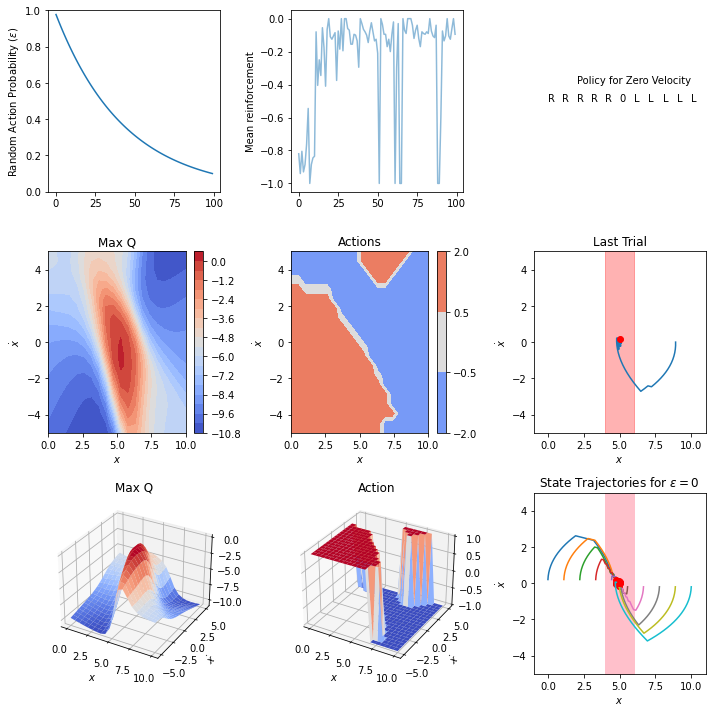

In [15]:
marble = Marble(valid_actions=np.array([-1, 0, 1]))

agent = Qnet(marble, hidden_layers=[10, 10],
             Xmeans=[5, 0, 0], Xstds=[2, 2, 0.8],
             Qmeans=[-2], Qstds=[1], use_gpu=False)

plt.ion()

epsilon_trace, r_trace =  agent.train(n_trials=100, n_steps_per_trial=200, n_epochs=500,
                                      method='sgd', learning_rate=0.01, gamma=0.9,
                                      epsilon=1, final_epsilon=0.1,
                                      trial_callback=plot_status)